ThinCurr Python Example: Compute Fourier transforms of normal magnetic field on a toroidal surface
==========
In this example we demonstrate how to compute Fourier transforms of the normal B field on an inner torus from a plasma filament drive, an outer torus, and a closed loop coil resembling a Runaway Electron Mitigation Coil (REMC).

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [ ]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.util import torus_fourier_sensor

## Compute Normal Magnetic Field

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using four threads and a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance that utilizes that execution environment. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". The XML file contains a plasma current filament on the magnetic axis (masked from sensor) and a closed-loop passive REMC coil plotted below.

We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/).

In [4]:
run_files = [f for f in os.listdir('.') if f.endswith('.rst') or f.endswith('.xmf')]
for file in run_files:
    os.remove(file)
    
save_files = [f for f in os.listdir('.') if f.startswith('mesh') or f.startswith('vector') or f.startswith('scalar') or f.startswith('dump.dat')]
for file in save_files:
    os.remove(file)

myOFT = OFT_env(nthreads=4)
tw_torus = ThinCurr(myOFT)
tw_torus.setup_model(mesh_file='thincurr_ex-torus.h5',xml_filename='oft_in_remc.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          0115fb8
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = /var/folders/d5/q37x15fn7t9g9bsh0n7b2jpm0000gn/T/oft_21965/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =        3122
  Loading V(t) driver coils
  Loading I(t) driver coils
  Masking coil    1 from sensors

  # of points    =         2394
  # of edges     =         7182
  # of cells     =         4788
  # of holes     =            2
  # of Vcoils    =            1
  # of closures  =            1
  # of Icoils    =            1

  Building holes

  Loading region resistivity:
     1  1.2566E-04


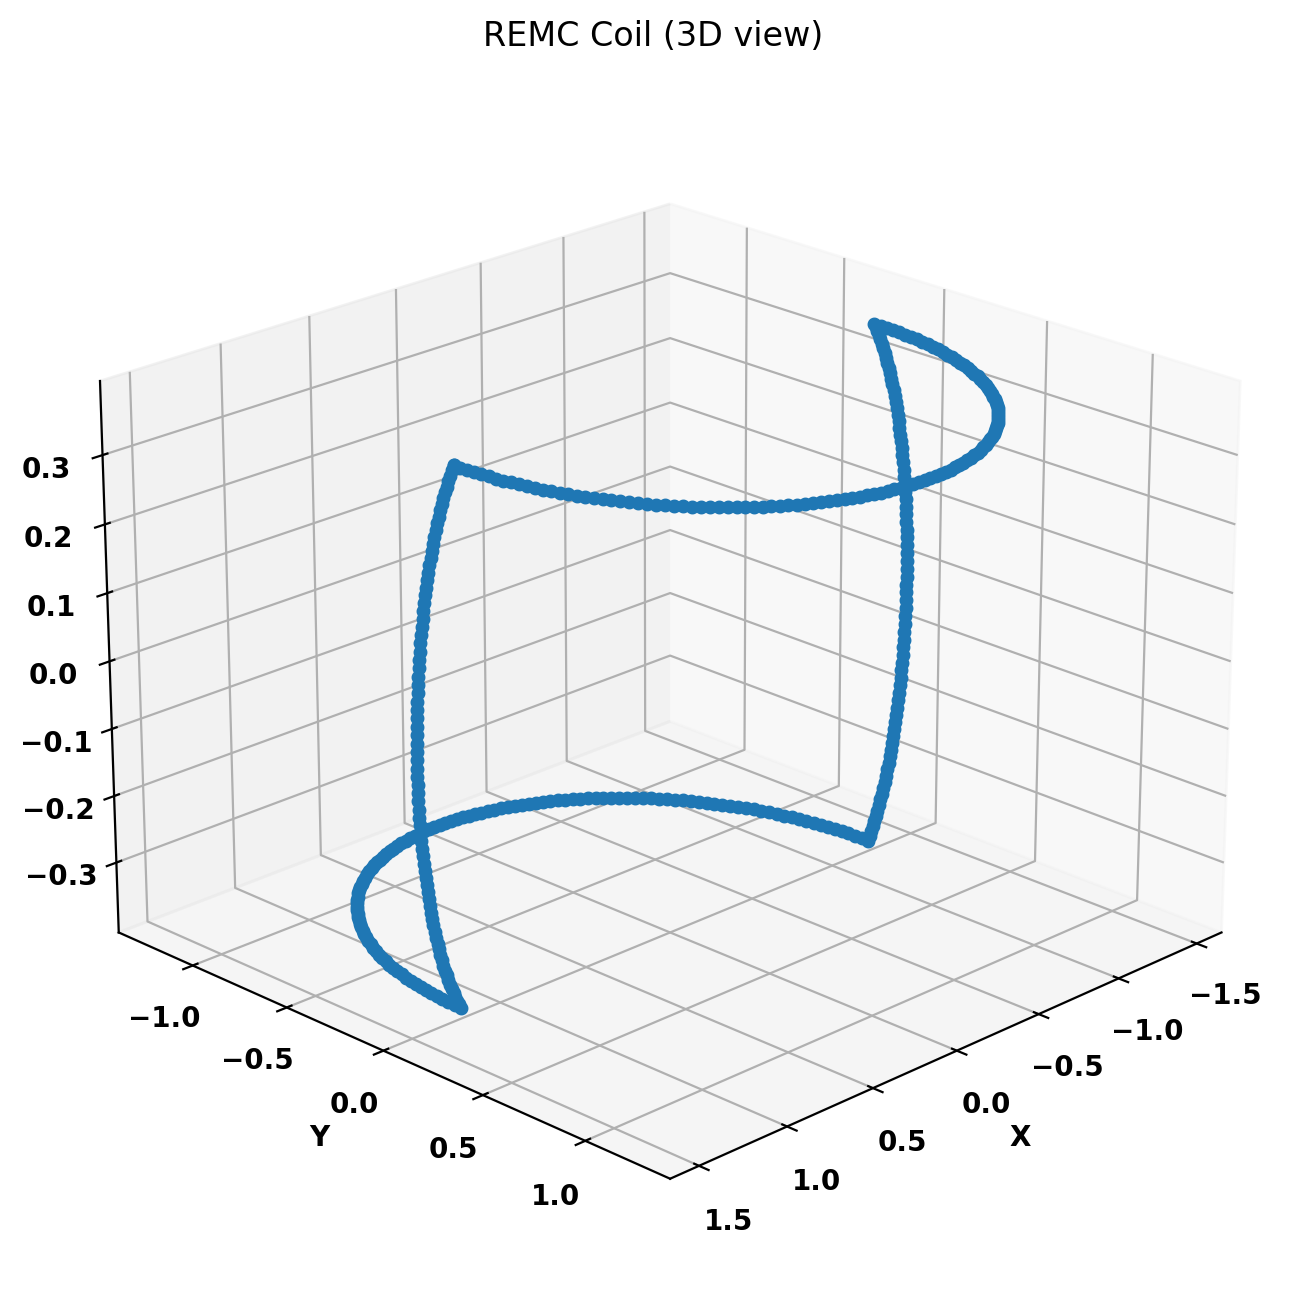

In [3]:
def read_oft_coil(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if '<coil res_per_len="2.195E-4" radius="0.005" npts="397"' in line:
            coil_start = i + 1
            break
    else:
        raise RuntimeError("No <coil> found.")

    for j in range(coil_start, len(lines)):
        if "</coil>" in lines[j]:
            coil_end = j
            break
    else:
        raise RuntimeError("No </coil> found.")

    points = []
    for line in lines[coil_start:coil_end]:
        line = line.strip()
        if line == "":
            continue
        x, y, z = map(float, line.split())
        points.append([x, y, z])
    points = np.array(points)
    return points

coil_points = read_oft_coil("oft_in_remc.xml")

fig = plt.figure(figsize=(12,8))
ax3d = fig.add_subplot(111, projection="3d")
ax3d.plot(coil_points[:,0], coil_points[:,1], coil_points[:,2], lw=2, marker='.')
ax3d.set_xlabel("X")
ax3d.set_ylabel("Y")
ax3d.set_zlabel("Z")
ax3d.set_title("REMC Coil (3D view)")
ax3d.view_init(elev=22, azim=45)
plt.show()

### Create an instance of the `torus_fourier_sensor` class

`torus_fourier_sensor` toroidally extends the definition of a poloidal cross section into a torus, and it places Mirnov sensors measuring outward normal magnetic fields on the torus's surface.  Here we initalize an instance of the class by first providing a major radius (for calculating outward normal vector) and a cross section (R,Z) definition calculated by GPEC (or specifically, by DCON's truncation) using a synthetic TokaMaker equilibrium that fits within a R=1, a=0.5 torus. The equilibrium asserts that the magnetic field on axis is in the same direction as the plasma current (by definition helicity = 1).

***Important Note:*** For coupling with GPEC and for running Fourier analysis in Hamada coordinates, the cross section used should be defined by the control surface calculated by GPEC and that `hamada_dphi` has to be provided to the Fourier analysis functions whenever possible. You can find the control surface definition and `hamada_dphi` (corresponding to `delta_phi`) in the `gpec_control_output_nX_nc` output tree of OMFIT GPEC once you've run a non-kinetic GPEC using the corresponding equilibrium. Check out [OMFIT GPEC tutorial](https://docs.google.com/document/d/1qSUjJZYmET8-X08rRGBT6L_9D9fzEN_zCV75OX_ZbZk/edit?tab=t.0) for more.

In [5]:
R_0 = 1.0
helicity = 1
ds = xr.open_dataset('torus_gpec_control_output_n1_nc.nc')
R_gpec=ds.R.to_dataframe().values[:,0][:-1]
Z_gpec=ds.z.to_dataframe().values[:,0][:-1]
delta_phi = ds.delta_phi.to_dataframe().values[:,0][:-1]

interface = torus_fourier_sensor(R_gpec,Z_gpec,R_0,helicity)

### Create sensor file through the `torus_fourier_sensor` class

Before running the main calculations we will also define some sensors to measure the magnetic field. In ThinCurr all sensors measure the flux passing through a 3D path of points, but there are several helper classes to define common sensors (eg. \ref OpenFUSIONToolkit.ThinCurr.sensor.circular_flux_loop "Poloidal flux" and \ref OpenFUSIONToolkit.ThinCurr.sensor.Mirnov "Mirnovs"). Here, the `torus_fourier_sensor`instance calculates outward normal vectors places on the poloidal cross section, places Mirnov sensors on them, and replicate the sensor surface toroidally. \ref OpenFUSIONToolkit.ThinCurr.sensor.save_sensors "save_sensors()" is then used to save the resulting sensor for later use, specifically the ThinCur model we created.

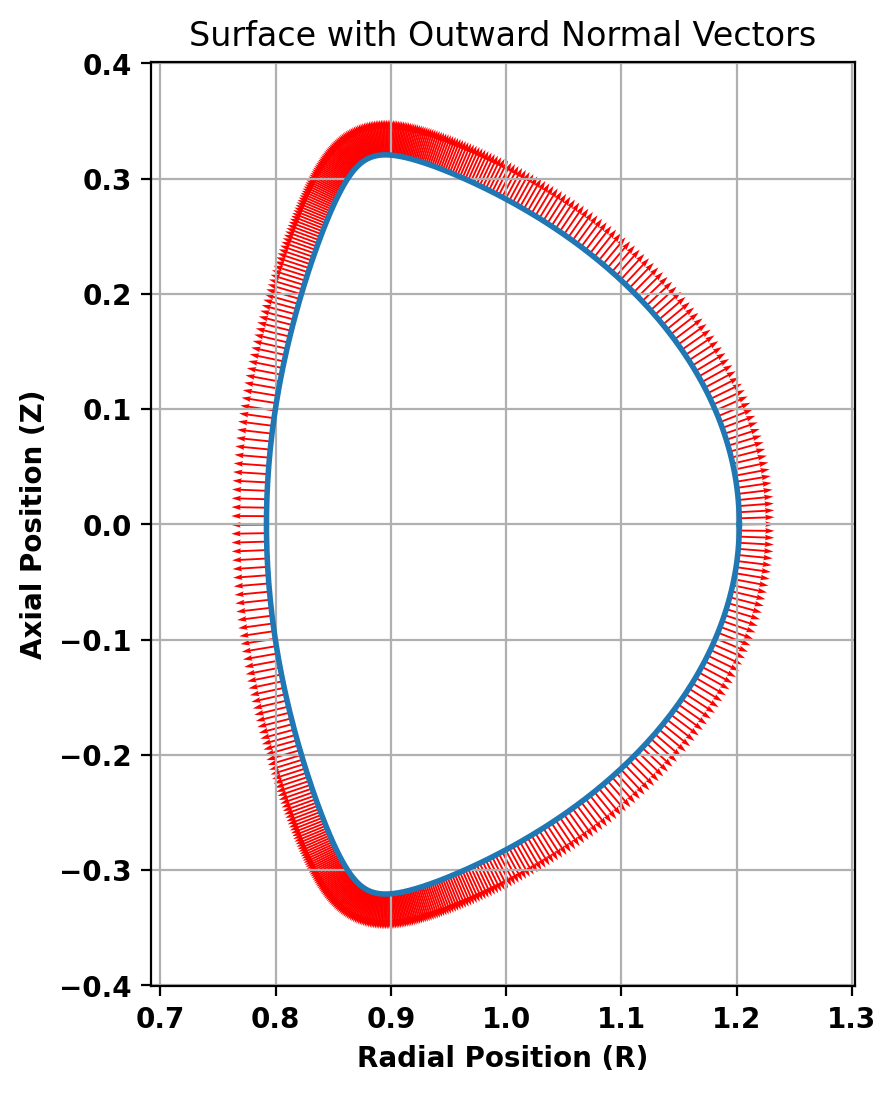

In [6]:
_,ax = plt.subplots(figsize=(10, 6))
interface.place_normal_sensors(nphi=15,filename='floops.loc',ax=ax)
plt.show()

### Compute inductance and resistivity matrices
With the model setup, we can now compute the inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_thincurr_ex4 for more information).

**Note:** HODLR is used in this notebook, whose relevant information can be found in other ThinCurr examples.

In [7]:
_, _, sensor_obj = tw_torus.compute_Msensor('floops.loc')
tw_torus.compute_Mcoil()
tw_torus.compute_Lmat(use_hodlr=True,cache_file='HODLR_L.save')
tw_torus.compute_Rmat()


 Loading floop information:
   # of floops =        7680
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix
 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
  Vcoil    1: L [H] =   1.3688E-05
 Partitioning grid for block low rank compressed operators
   nBlocks =                   2
   Avg block size =         1196
   # of SVD =                  1
   # of ACA =                  0

 Building block low rank inductance operator
   Building hole and Vcoil columns
   Reading HODLR matrix from file: HODLR_L.save
   Building diagonal blocks
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     Compression ratio:  62.1%  ( 3.56E+06/ 5.73E+06)
     Time =  0s          
 Building resistivity matrix
  Vcoil    1: R [Ohm] =   2.1032E-03


## Run time-domain simulation
With the model fully defined we can now use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" to perform a time-domain simulation. In this case we simulate 40 ms using a timestep of 0.2 ms (200 steps). We also specify the current in the single I-coil defined in the XML input file as a function of time (`coil_currs`), where the first column specifies time points in ascending order and the remaining columns specify coil currents at each time point.

In [8]:
dt = 2.E-4
nsteps = 200
coil_currs = np.array([
    [0.0, 1.E6],
    [4.E-3, 0.0],
    [1.0, 0.0]
])
tw_torus.run_td(dt,nsteps,status_freq=10,coil_currs=coil_currs,sensor_obj=sensor_obj)


 Starting simulation
 Timestep           10   2.00000009E-03   13.8340416              22
 Timestep           20   4.00000019E-03   21.9472332              22
 Timestep           30   6.00000005E-03   13.6633396              23
 Timestep           40   8.00000038E-03   8.69305325              22
 Timestep           50   9.99999978E-03   5.72928953              22
 Timestep           60   1.20000001E-02   3.89113545              22
 Timestep           70   1.40000004E-02   2.71221662              22
 Timestep           80   1.60000008E-02   1.93318379              22
 Timestep           90   1.79999992E-02   1.40424693              22
 Timestep          100   1.99999996E-02   1.03621030              22
 Timestep          110   2.19999999E-02  0.774476469              22
 Timestep          120   2.40000002E-02  0.584817231              22
 Timestep          130   2.60000005E-02  0.445175737              22
 Timestep          140   2.80000009E-02  0.341005892              22
 Timestep   

### Compute B-field reconstruction operator

In [9]:
_, Bc = tw_torus.compute_Bmat(cache_file='HODLR_B.save')

 Building block low rank magnetic field operator
   Building hole and Vcoil columns
   Reading HODLR matrix from file: HODLR_B.save
   Building diagonal blocks
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     Compression ratio:  63.2%  ( 1.09E+07/ 1.72E+07)
     Time =  0s          


### Generate plot files from run

In [10]:
tw_torus.plot_td(nsteps,compute_B=True,sensor_obj=sensor_obj)
_ = tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
  Removed 0 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: thincurr
    Found Mesh: icoils
    Found Mesh: smesh
    Found Mesh: vcoils


### Load sensor signals from time-domain run to the `torus_fourier_sensor` instance

In [11]:
interface.load_histfile(hist_file_path='floops.hist')

## Visualize the normal B field in real and Fourier space

### Initialize the time step and the Fourier modes to be analyzed

In [12]:
# Choose a time step within the the time-domain simulation
t = 80
# Choose one or some Fourier modes;
# Don't forget to change harmonic flags (i.e., toroidal_harmonics) to identify if input modes are poloidal or toroidal modes
n = 1
n_list = [0,1]
m_list = [5,7,2,4,1]

### Visualize the sensor signals on the toroidal surface

The first two plots are raw signal mesh and the inverse Fourier transform of the Fourier transform of the raw mesh--evidently they should match if the code works properly. The last plot is simply the information of the first at phi=0 plotted as a 2D line graph.

We can notice the effect of REMC from the change in signal strength around phi=2.8 and 5.7.

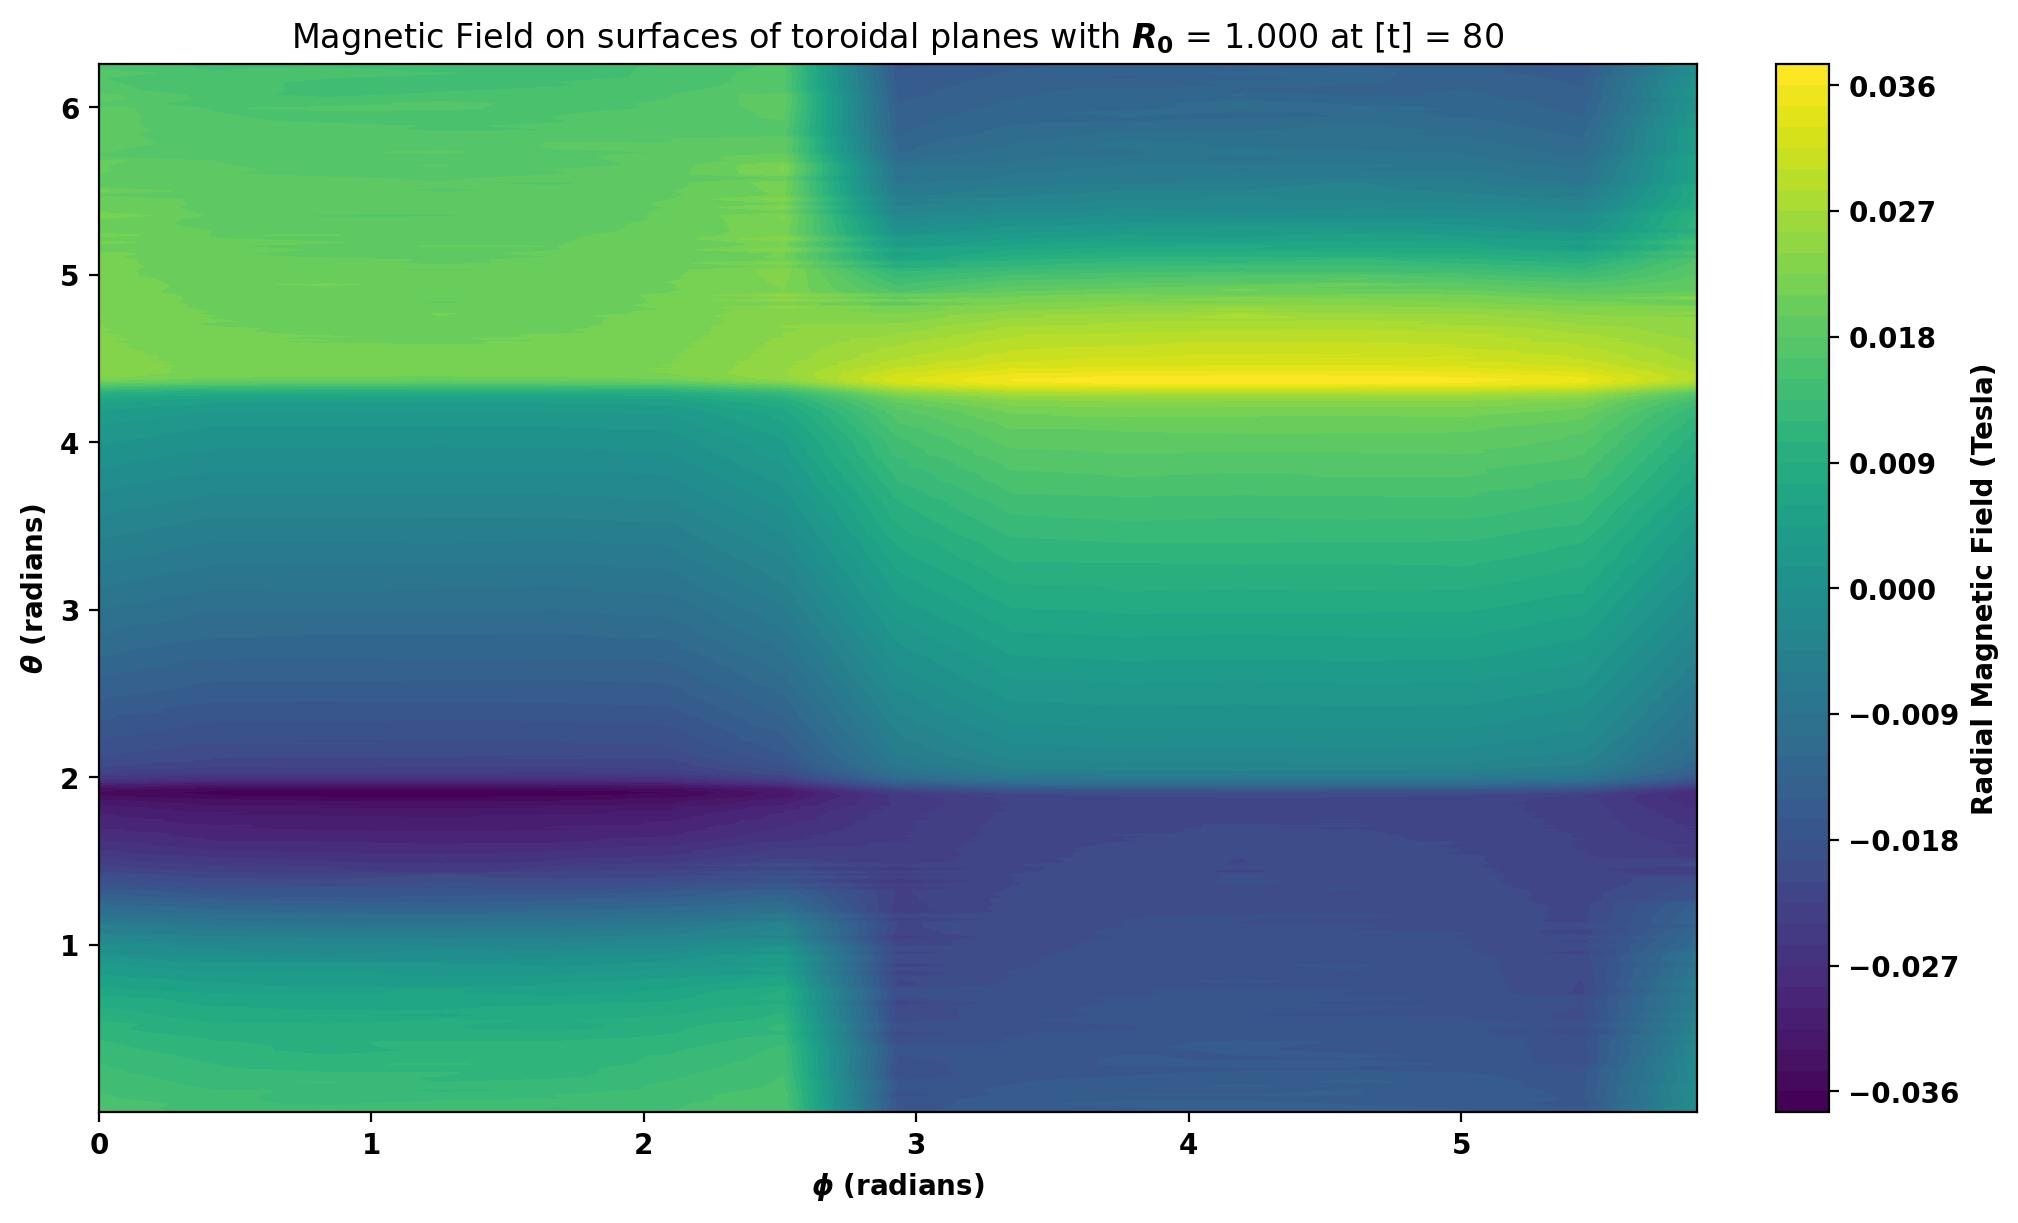

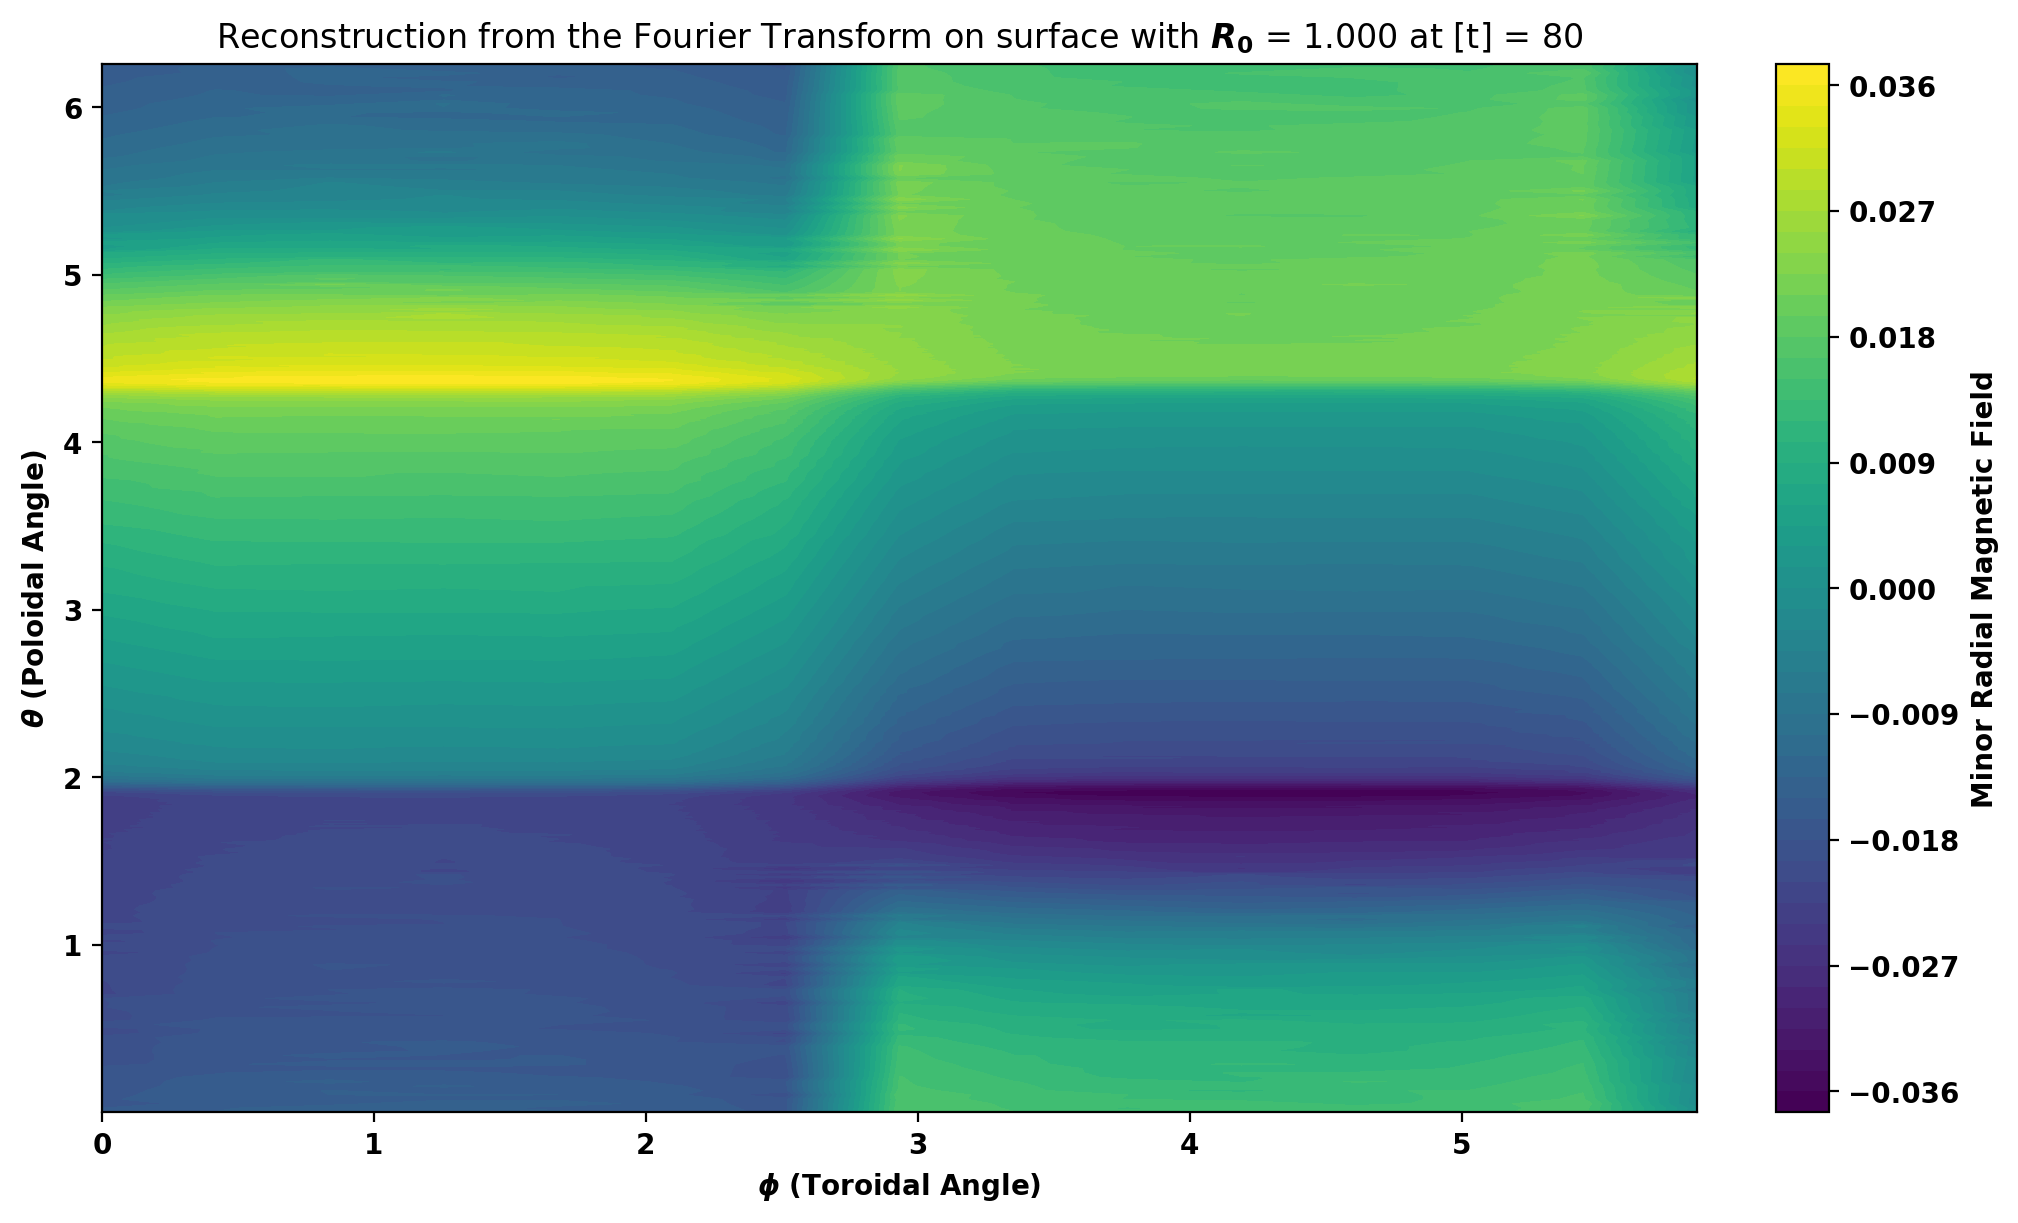

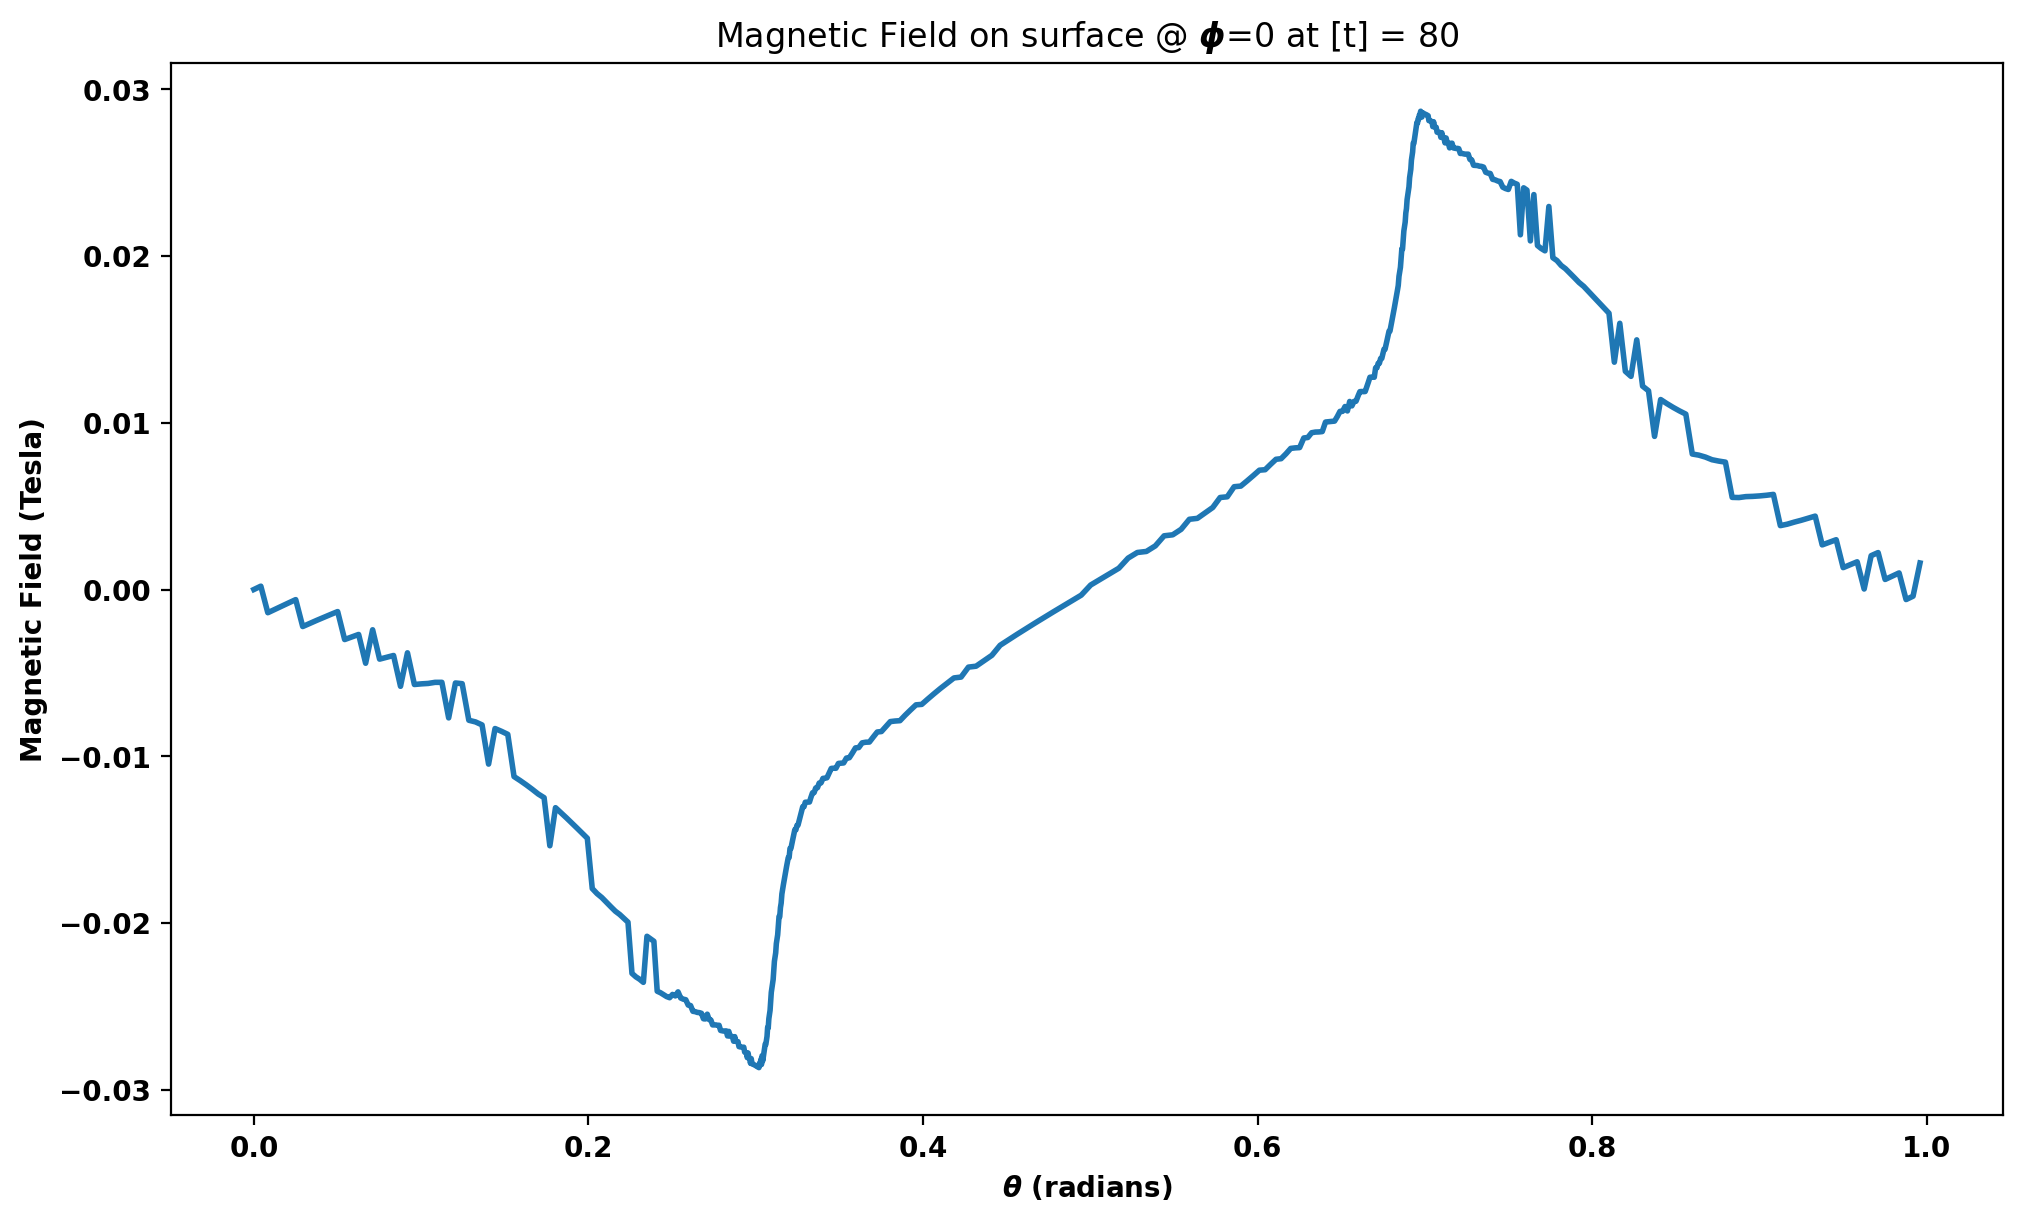

In [13]:
fig,ax = plt.subplots(figsize=(10,6),constrained_layout=True)
interface.plot_sensor_output(t,fig,ax)
fig,ax = plt.subplots(figsize=(10,6),constrained_layout=True)
interface.plot_inverse_2D_fourier_transform(t,fig,ax)
_,ax = plt.subplots(figsize=(10,6),constrained_layout=True)
interface.plot_sensor_signal_against_angle(t,ax,theta=True)
plt.show()

Here are two plots showing the outward normal magnetic fields on two different poloidal cross sections.

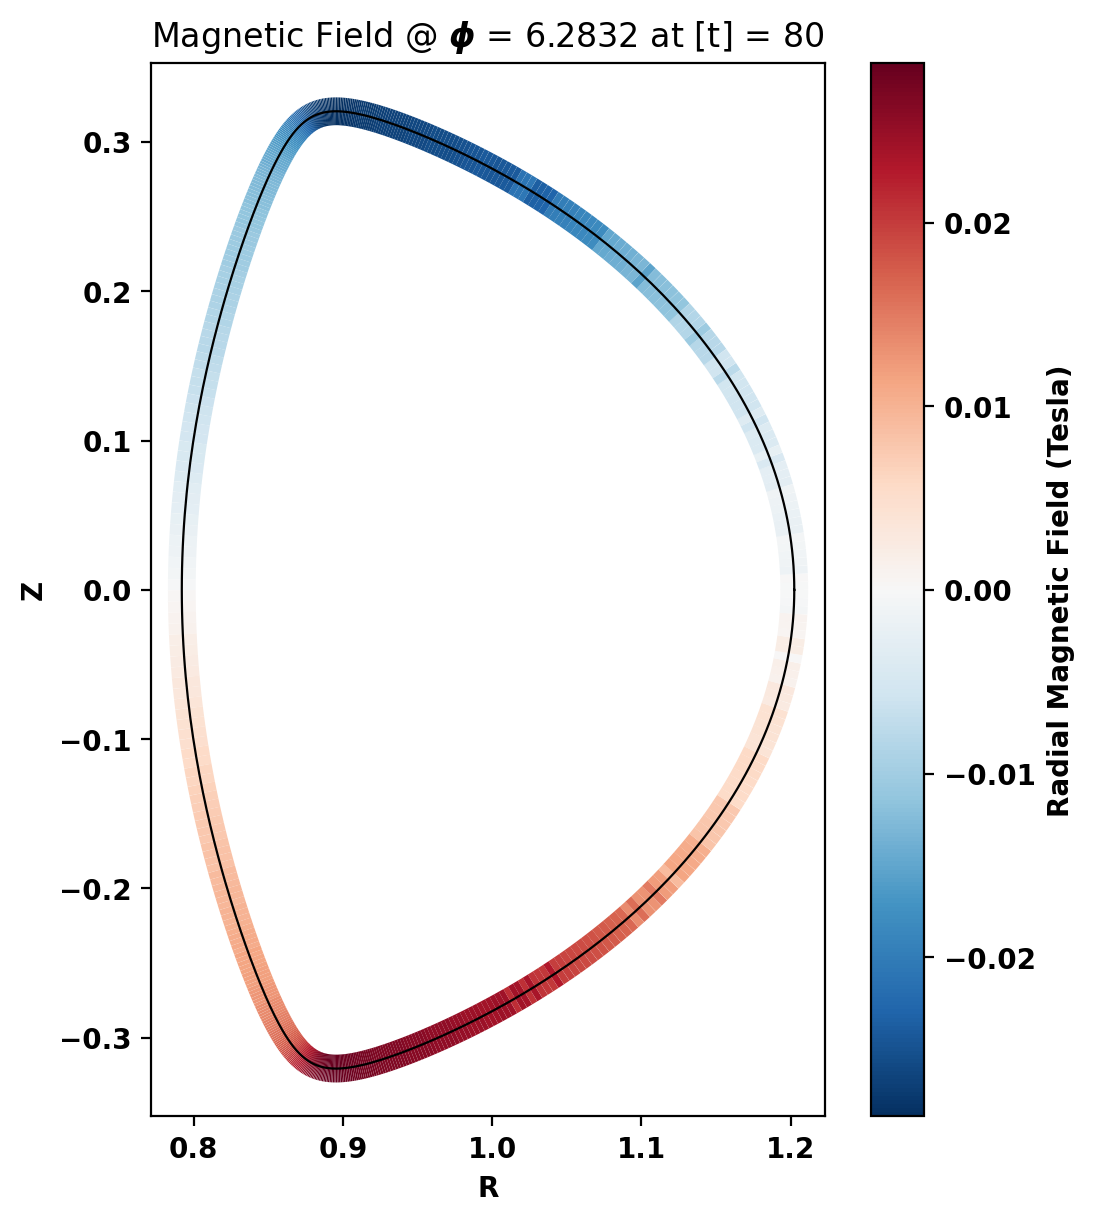

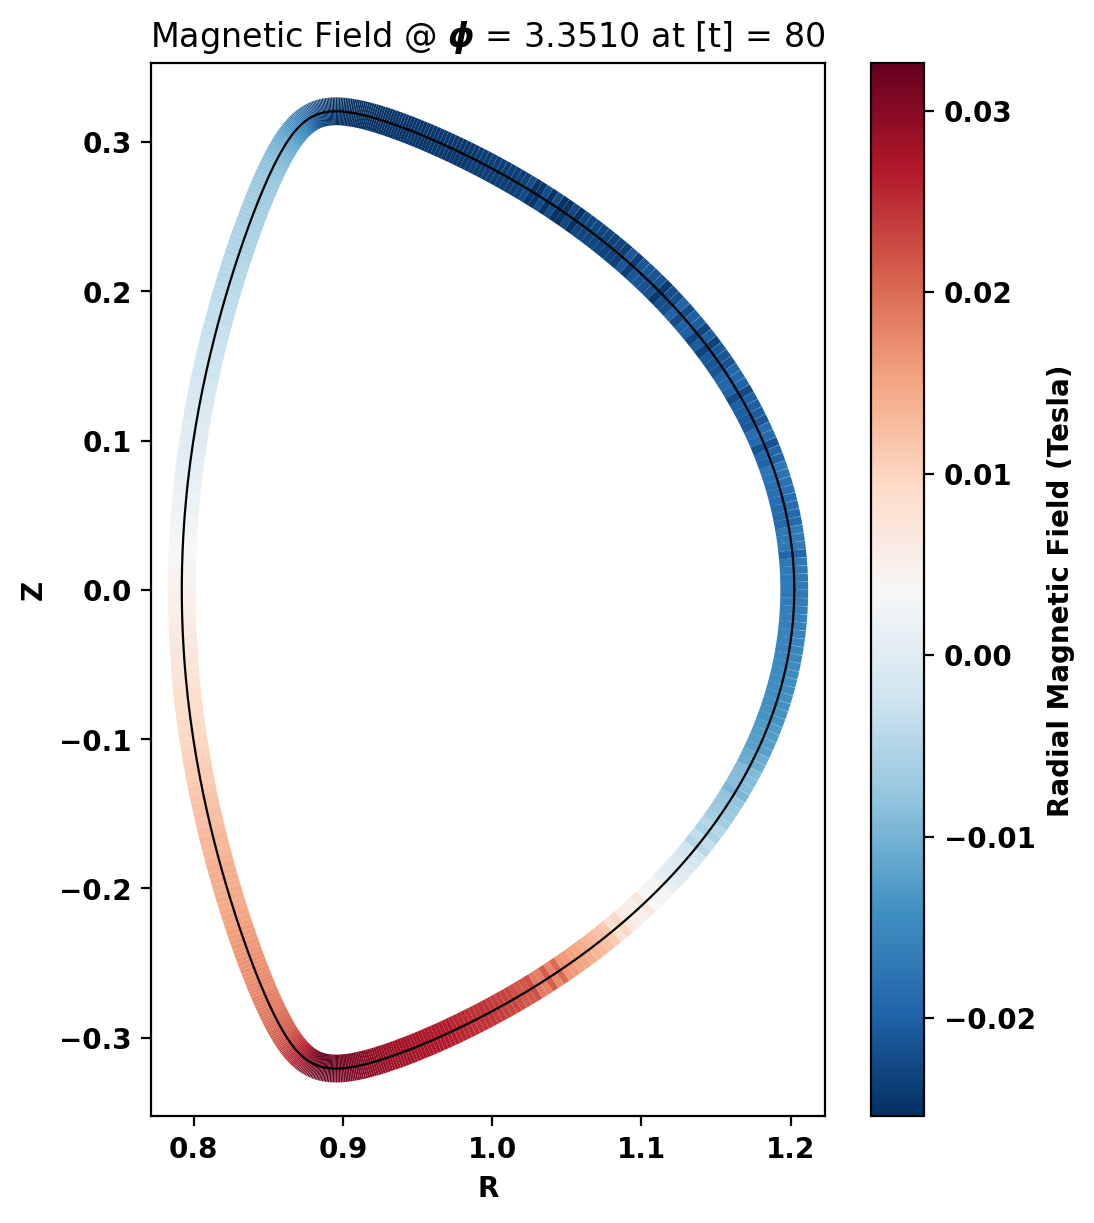

In [14]:
fig1,ax1 = plt.subplots(constrained_layout=True)
fig2,ax2 = plt.subplots(constrained_layout=True)
interface.plot_sensor_output_on_surface(t,[fig1,fig2],[ax1,ax2])
plt.show()

Next are two plotting functions in which 1D Fast Fourier Transform is performed on the `axis` specified (poloidal = 0, toroidal = 1). They only differ in the part of the Fourier amplitudes shown.

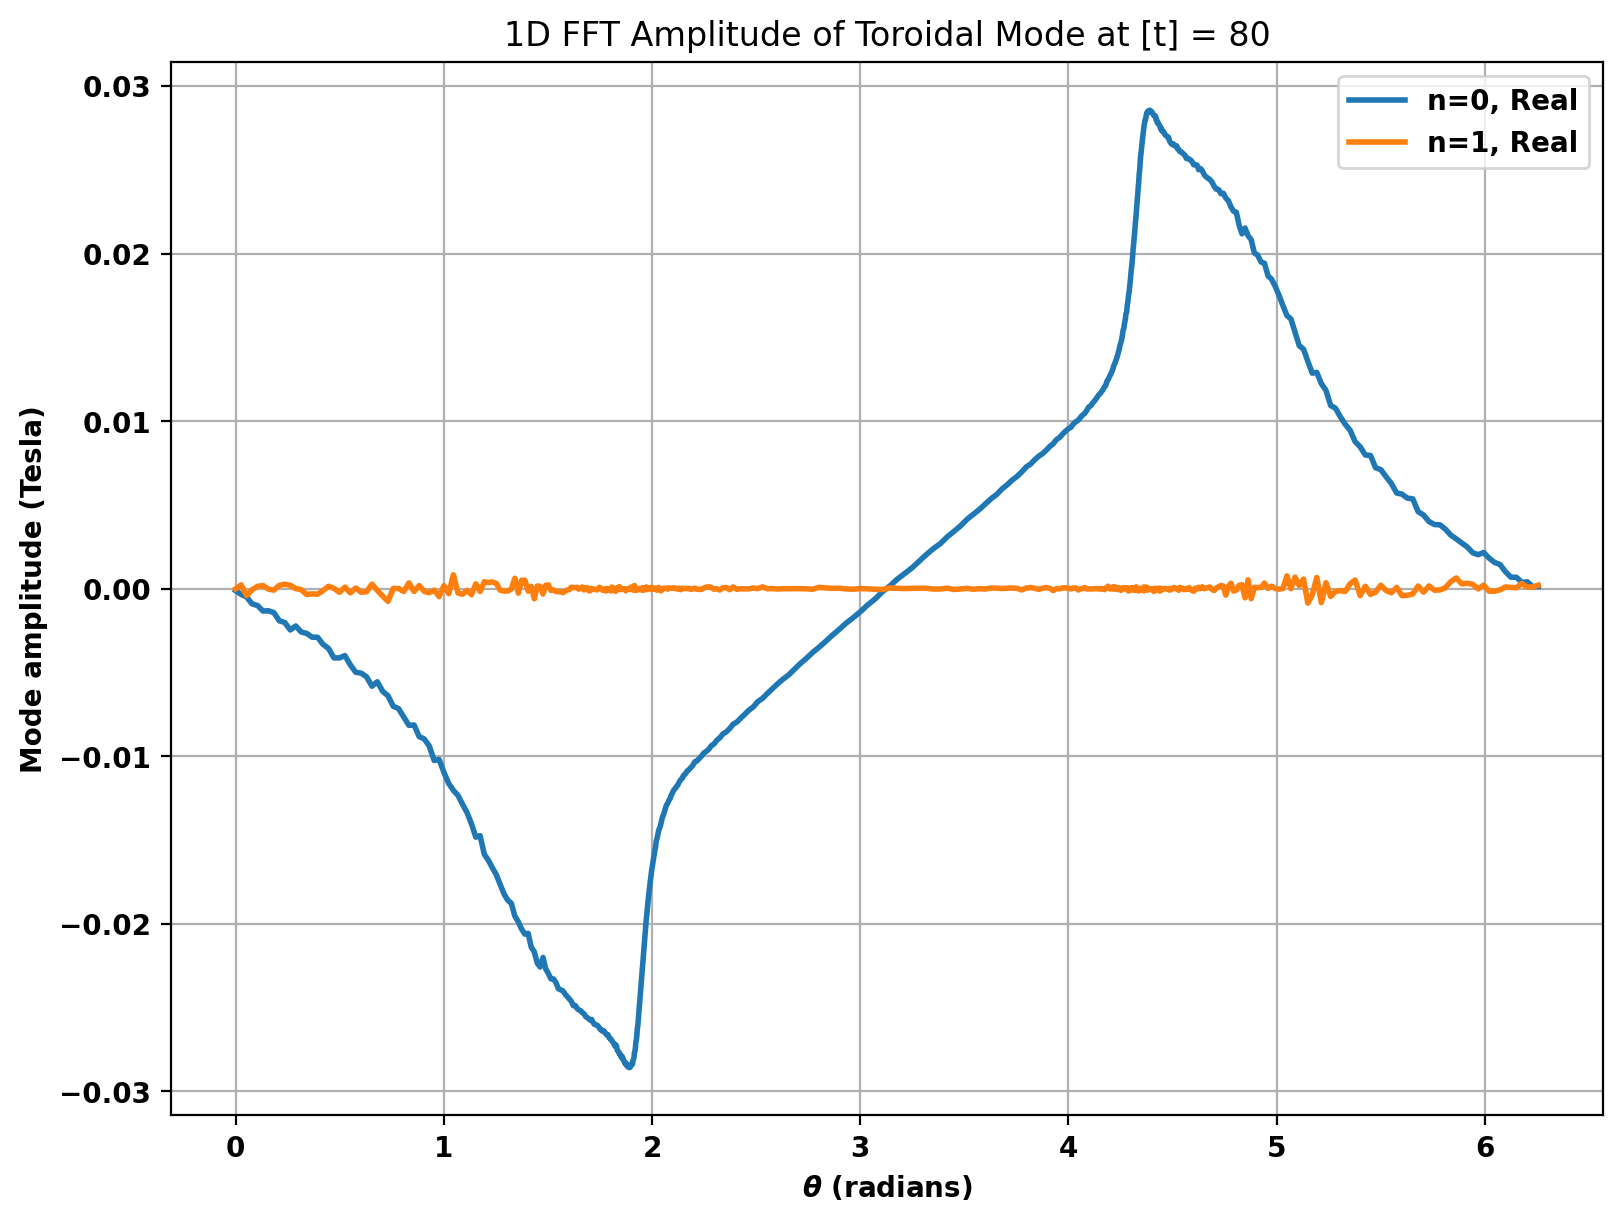

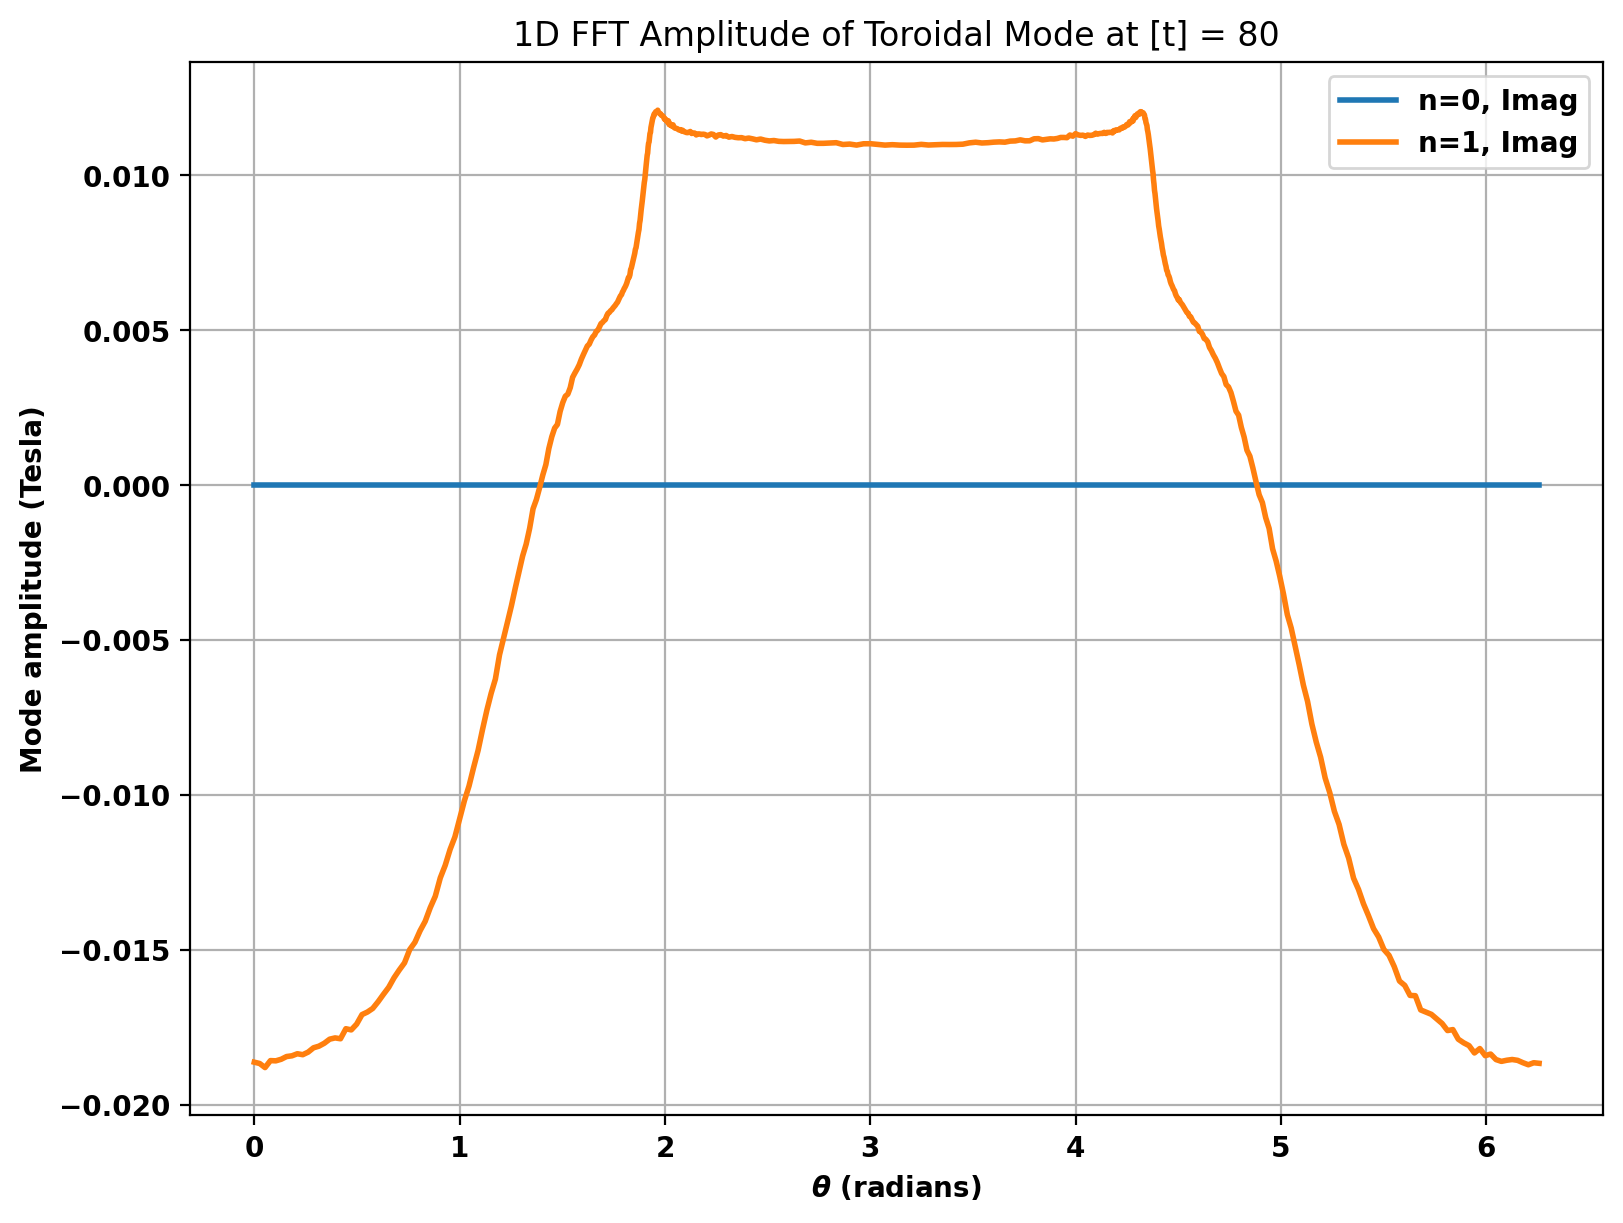

In [15]:
# Feel free to switch to Hamada coordinates by providing `hamada_dphi = delta_phi`
_,ax = plt.subplots(figsize=(8,6),constrained_layout=True)
interface.plot_1D_fourier_amplitude(t,n_list,ax,toroidal_harmonics=True,part='r',hamada_dphi=None)
_,ax = plt.subplots(figsize=(8,6),constrained_layout=True)
interface.plot_1D_fourier_amplitude(t,n_list,ax,toroidal_harmonics=True,part='i',hamada_dphi=None)
plt.show()

Finally, we can perform 2D Fast Fourier Transform on the sensor signal mesh through these plotting methods, and there are various ways we can visualize the results. 

If you followed the coupling procedures (used control surface and `hamada_dphi = delta_phi` from GPEC), you can run **"interface.save_surfmn(t,filename,eliminate_negative_n=True,scale=1e-4,hamada_dphi=None)"** to output the normal magneic field's 2D Fourier transform in a SURFMN-formatting file that can be input to GPEC as perturbations on the control surface. In this case, we've masked the driving current filament in `oft_in_remc.xml`, so the eddy currents in the torus and inductive currents in REMC are the perturbation sources.

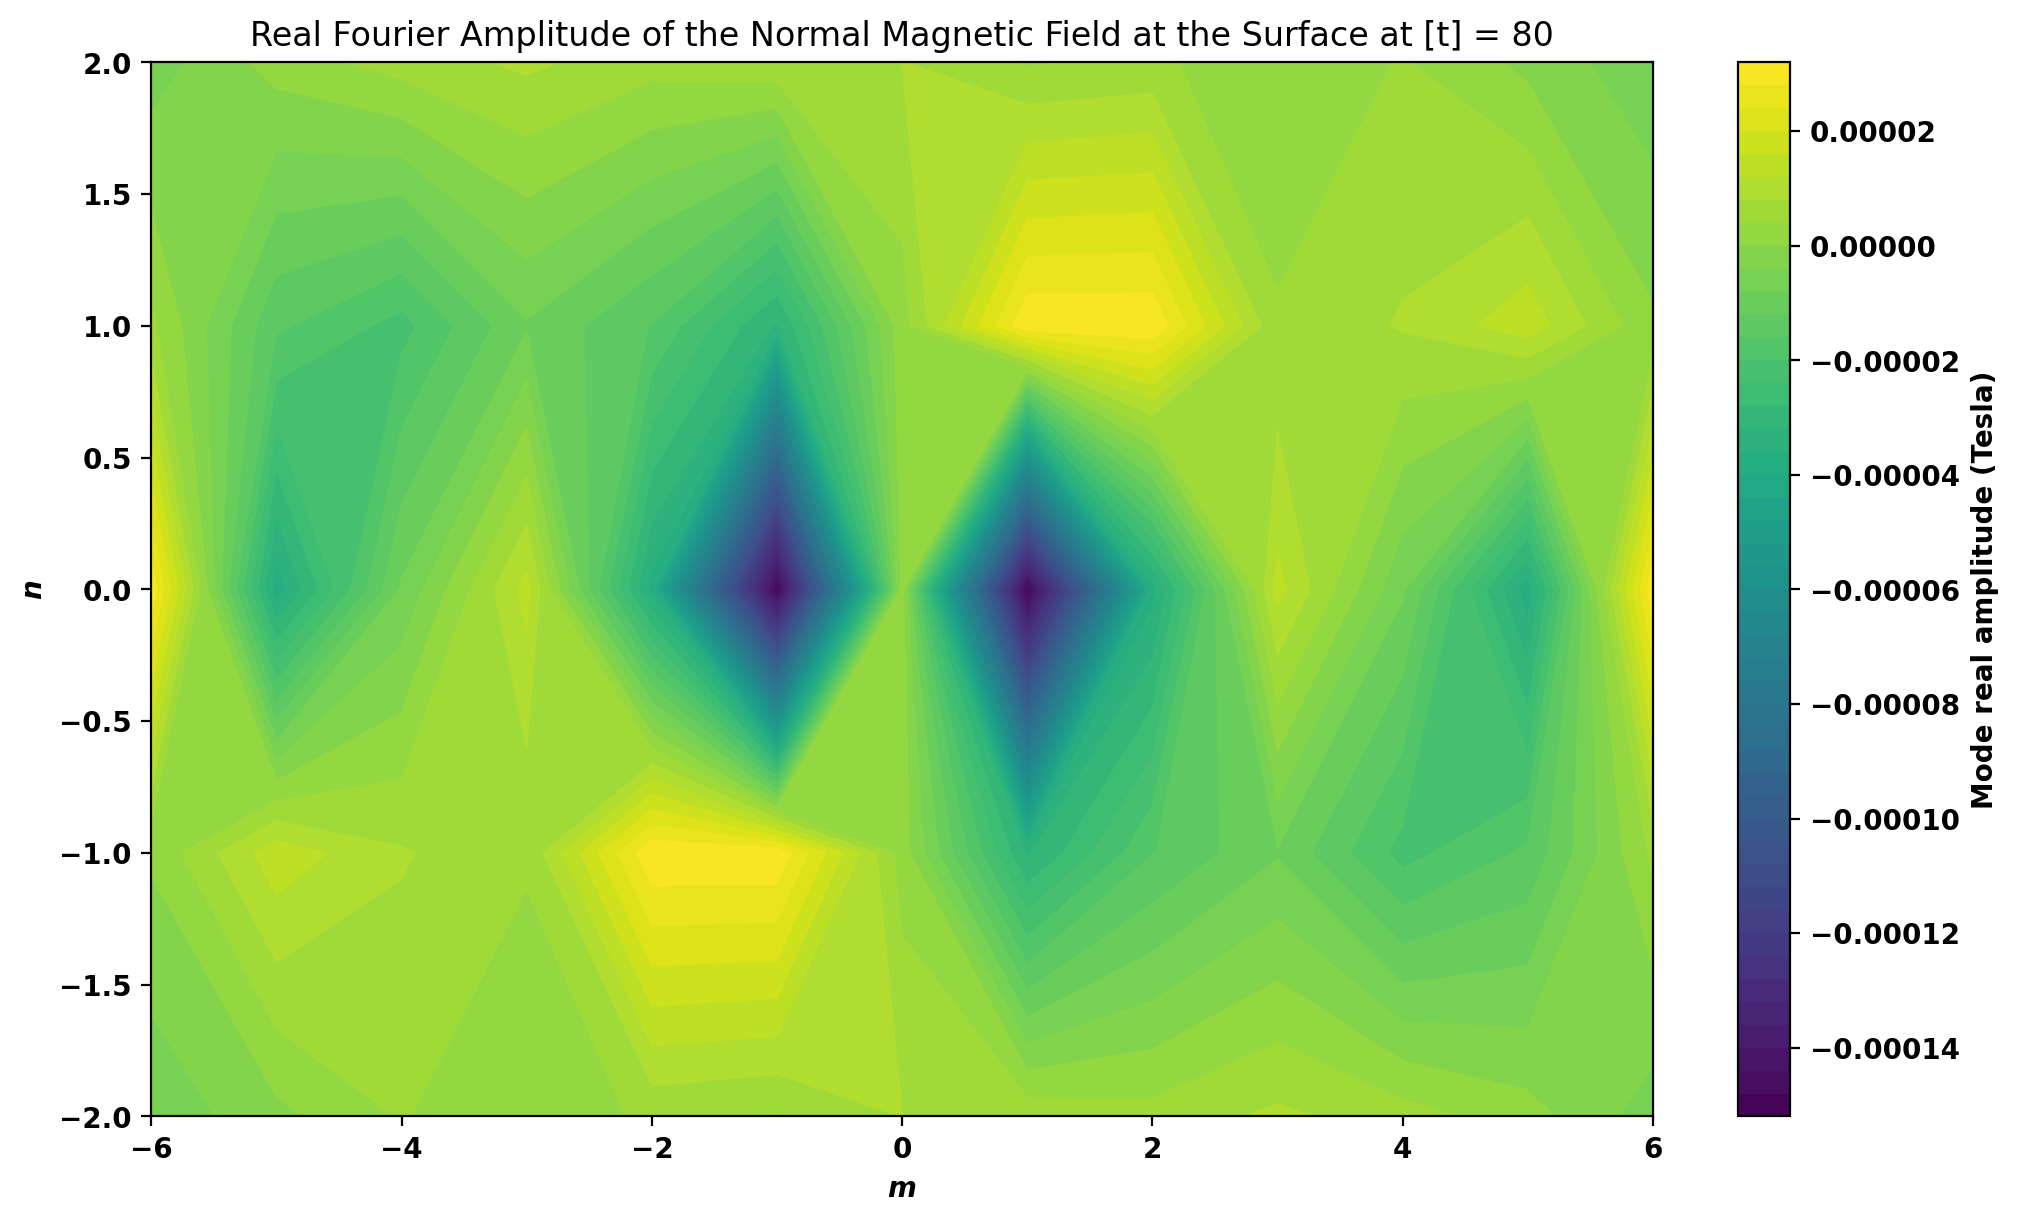

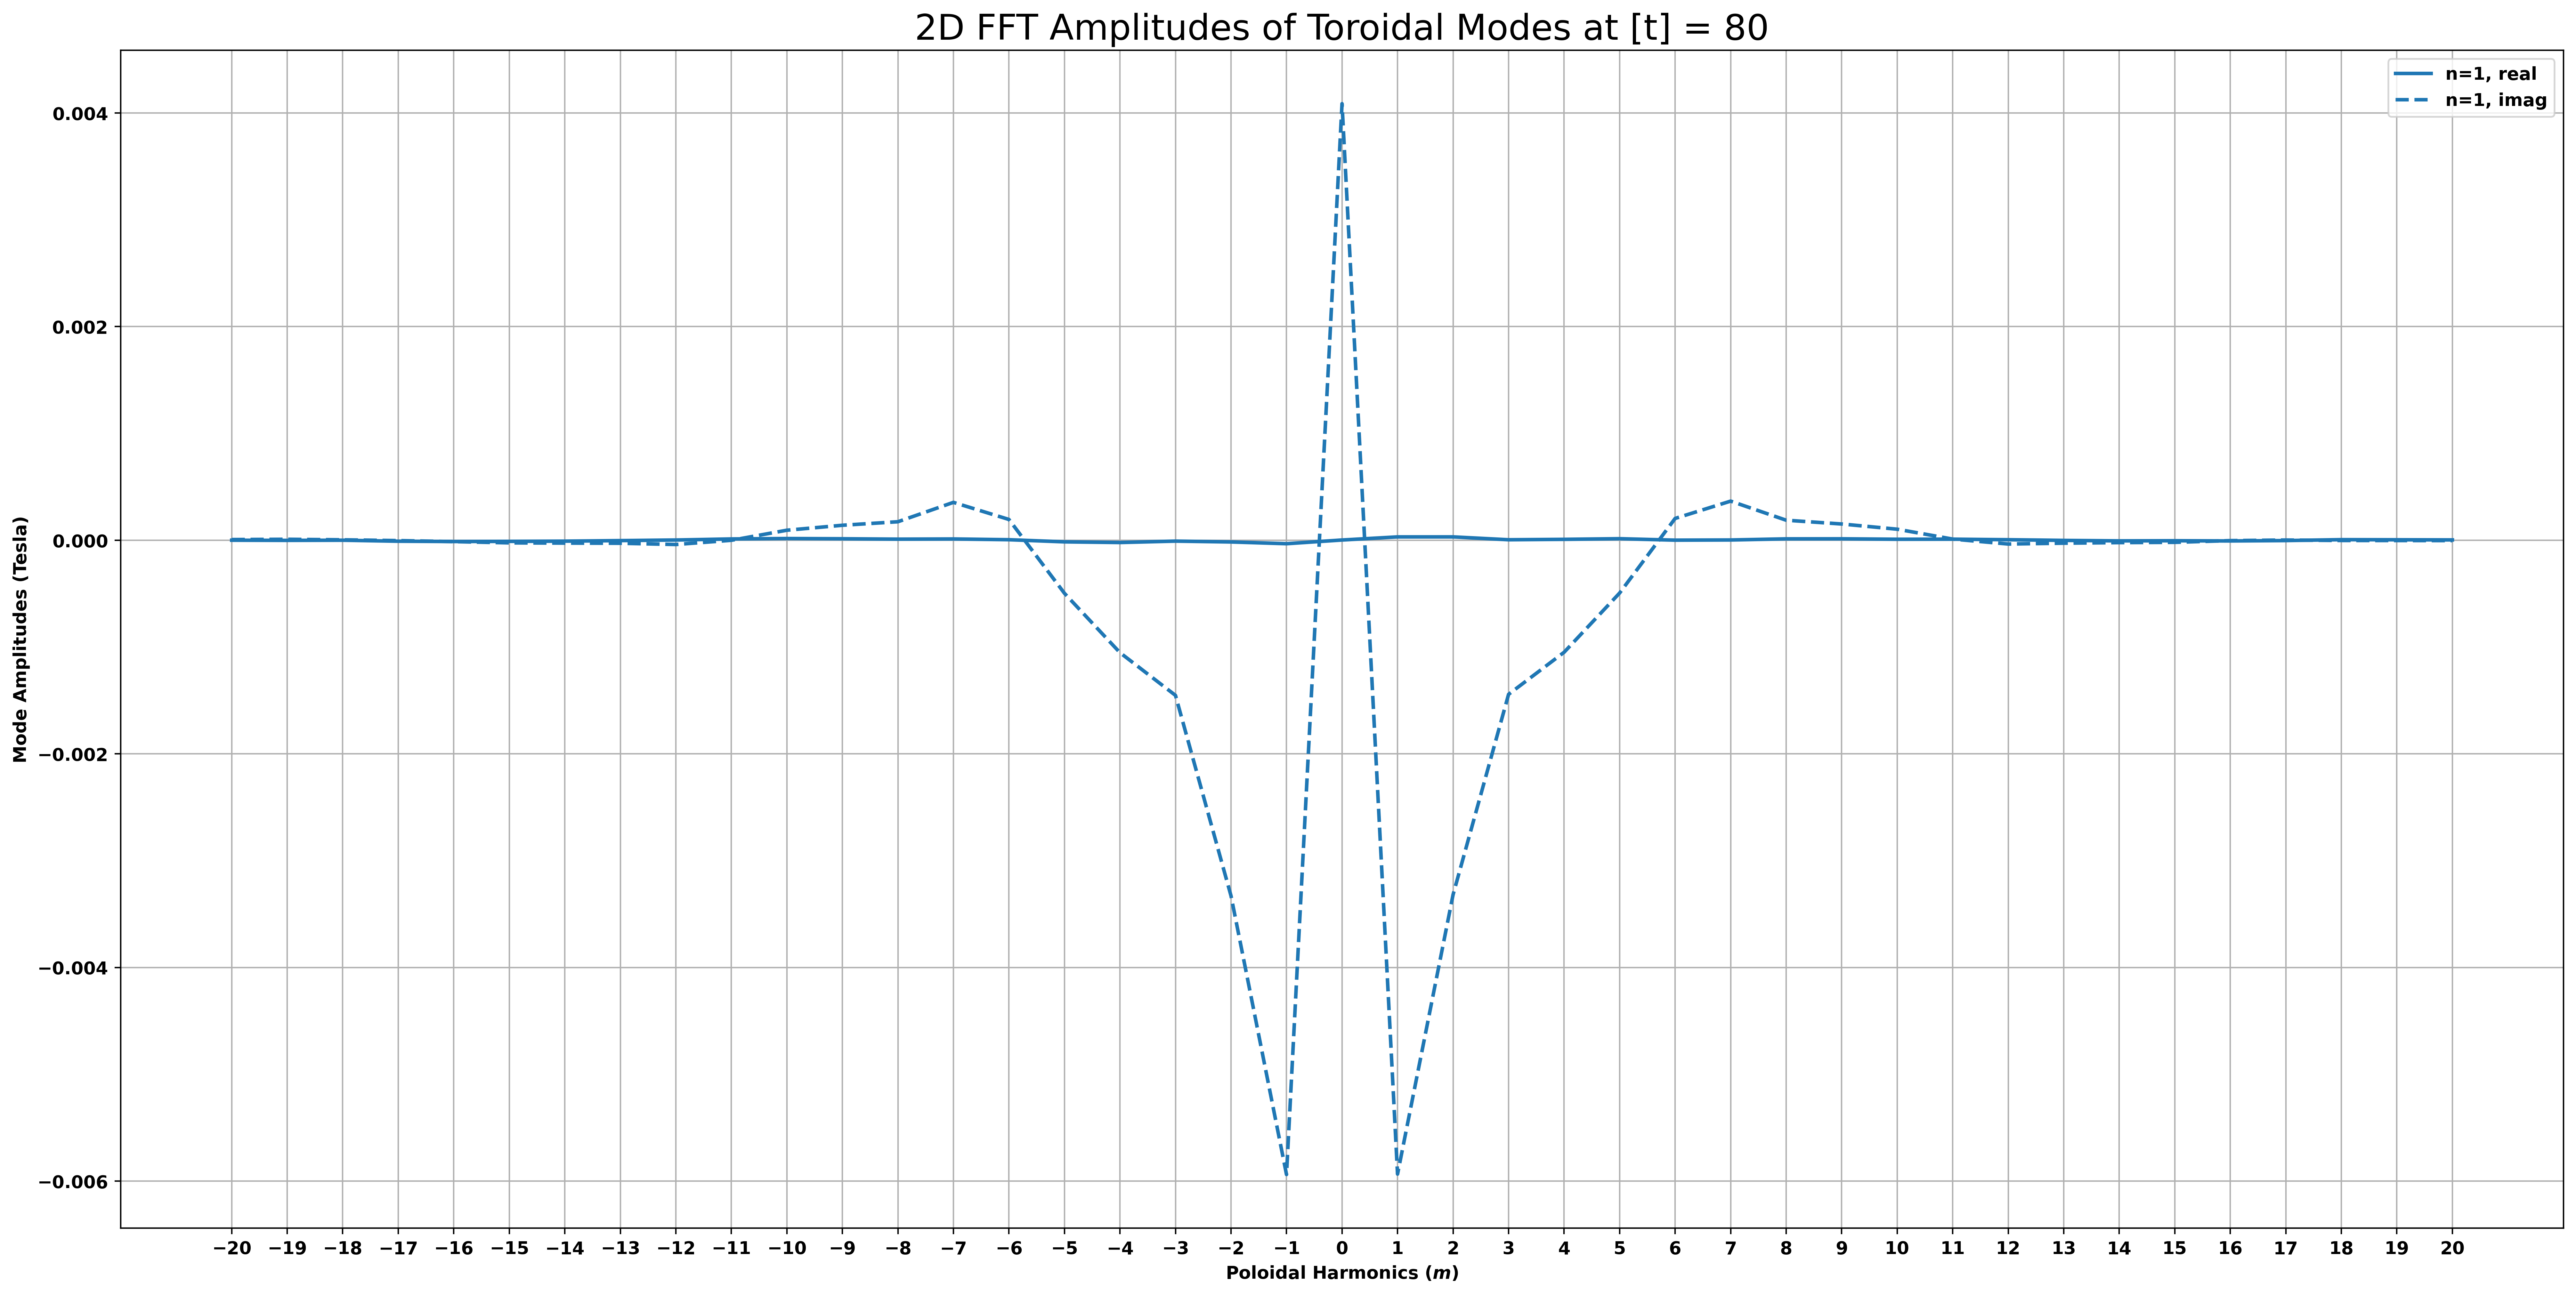

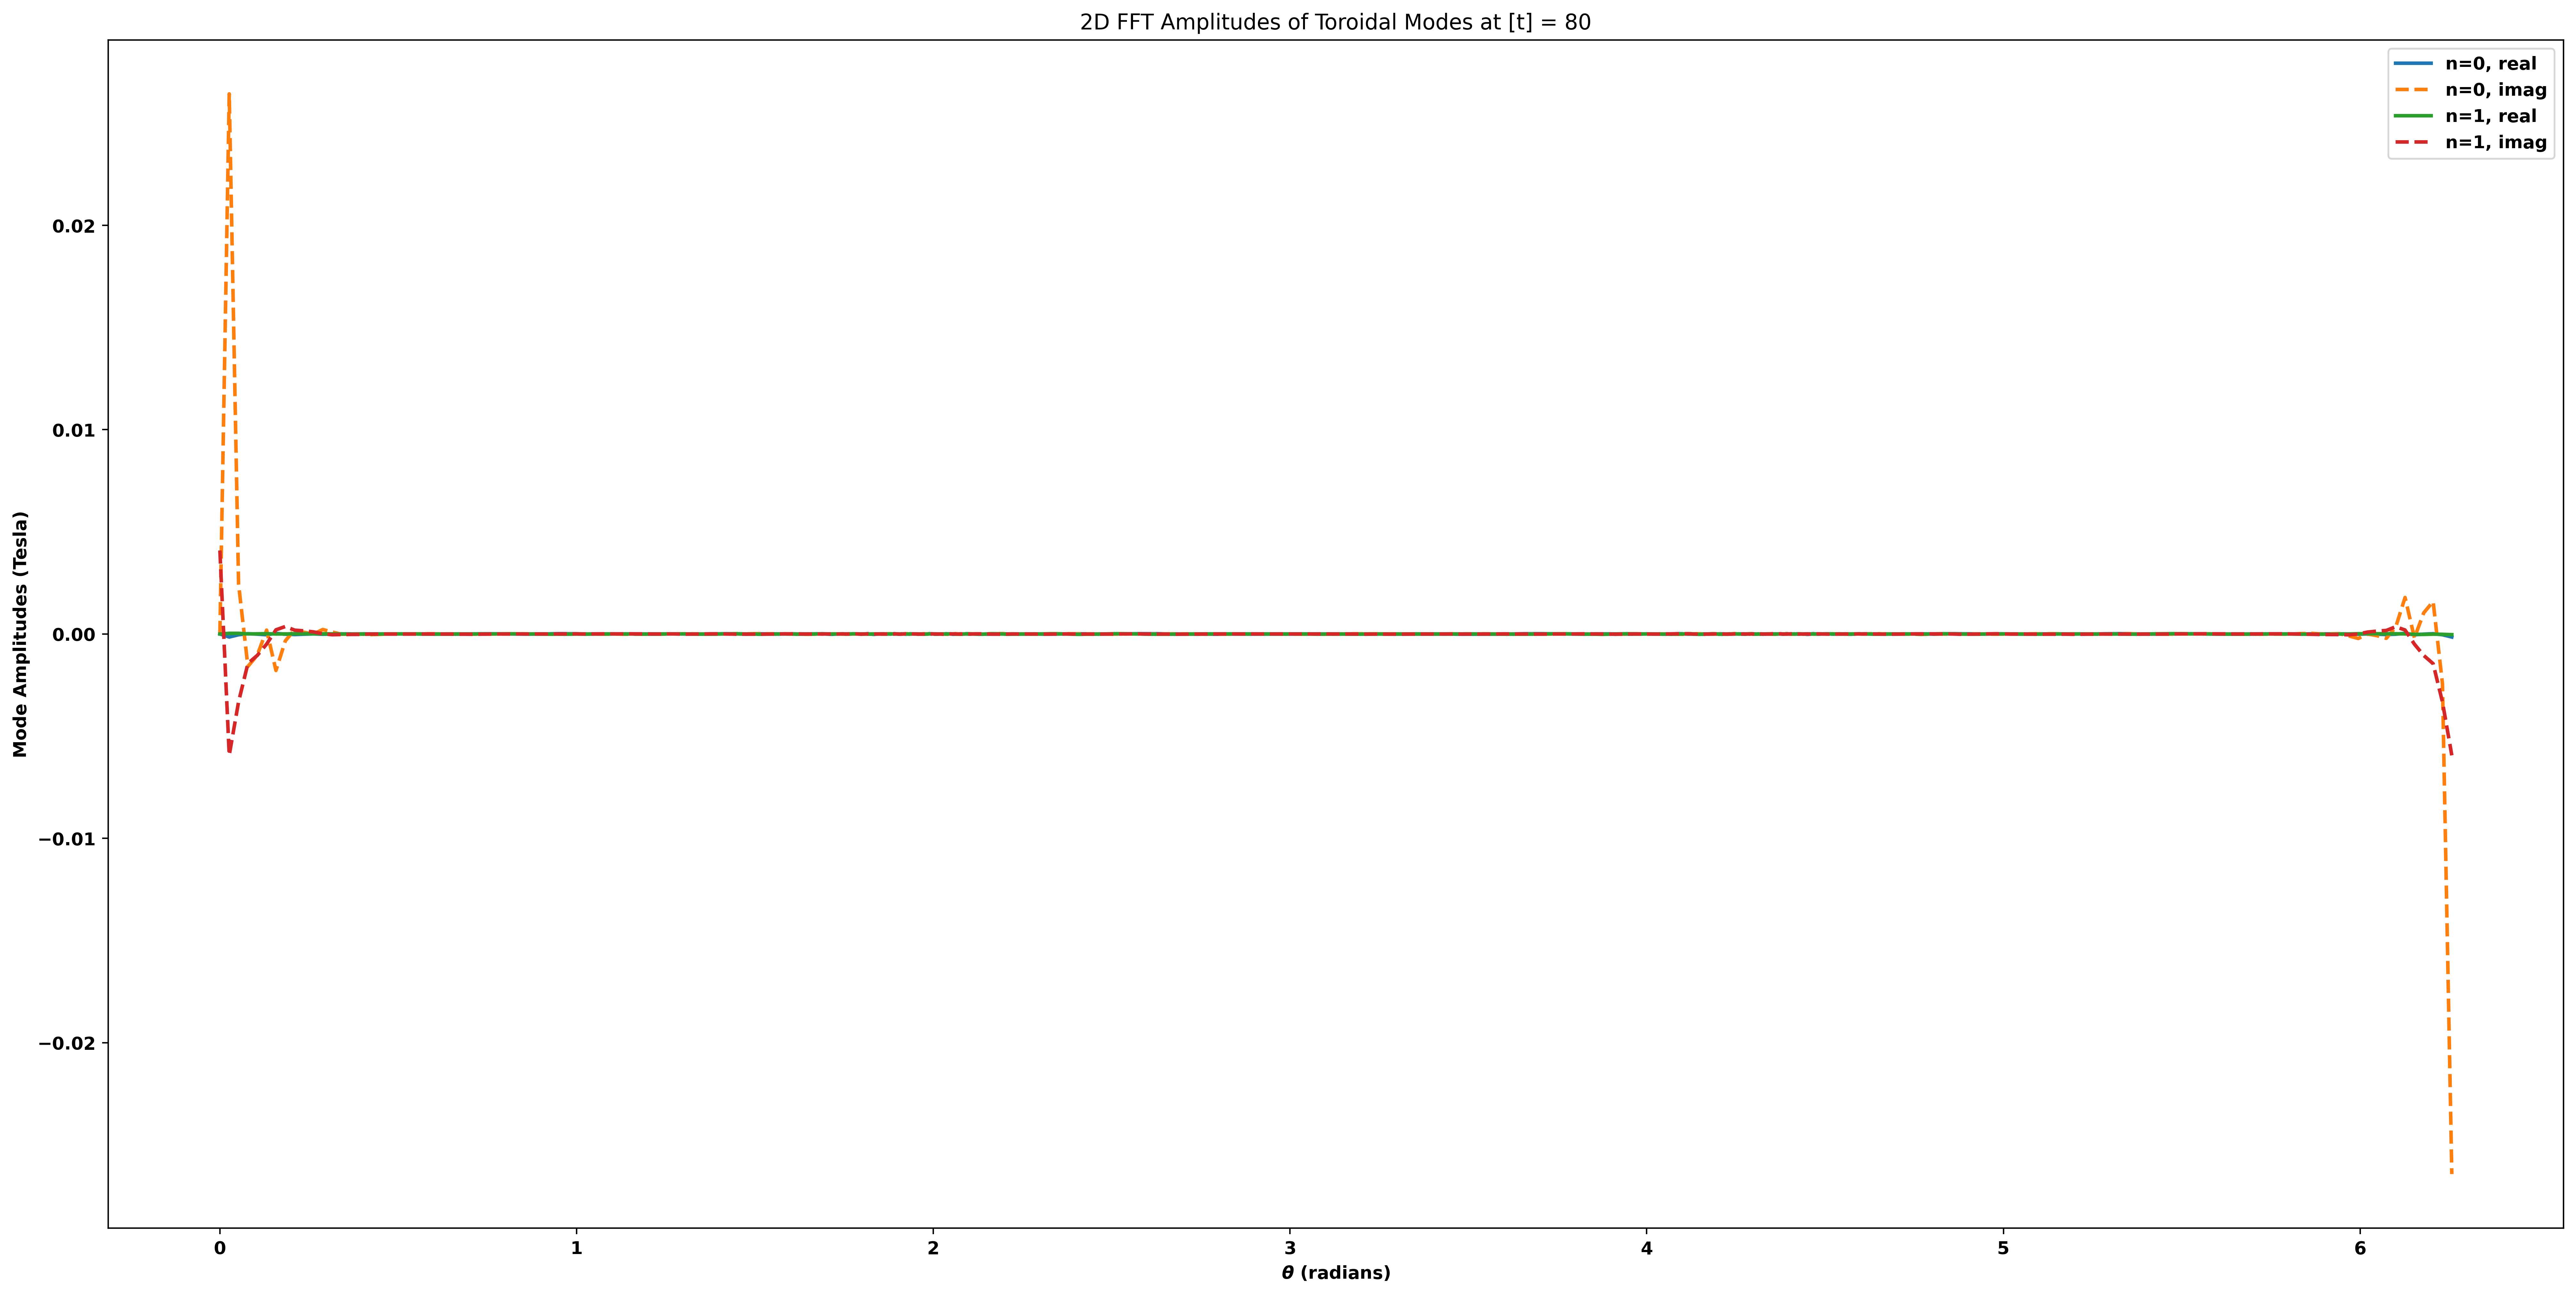

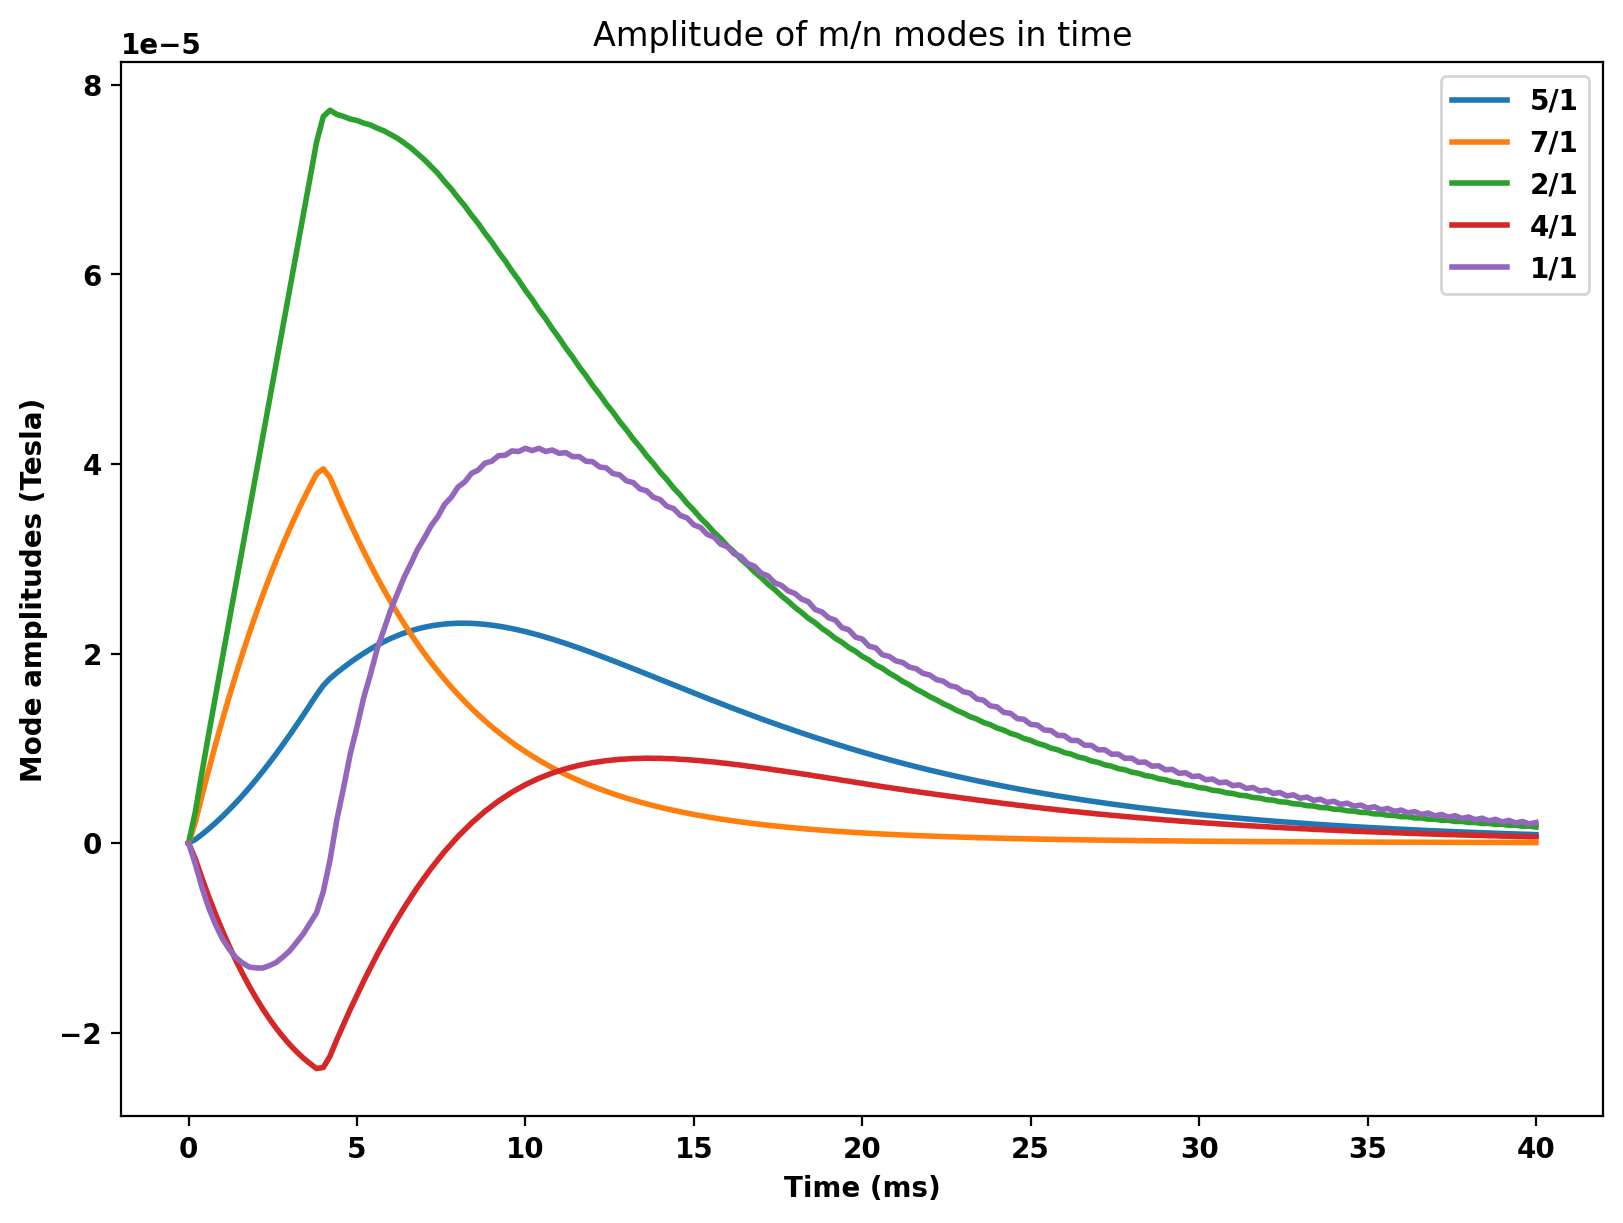

In [16]:
# Feel free to switch to Hamada coordinates by providing `hamada_dphi = delta_phi`
fig,ax = plt.subplots(figsize=(10,6),constrained_layout=True)
interface.field_fourier_amplitude_contour(t,m_min=-6,m_max=6,n_min=-2,n_max=2,fig=fig,ax=ax,part='r',hamada_dphi=None)
_,ax = plt.subplots(figsize=(20,10),dpi=200,constrained_layout=True)
interface.plot_2D_fourier_amplitude(t,n,ax,toroidal_harmonics=True,x_type='modes',x_mode_min=-20,x_mode_max=20,hamada_dphi=None)
_,ax = plt.subplots(figsize=(20,10),dpi=200,constrained_layout=True)
interface.plot_2D_fourier_amplitude(t,n_list,ax,toroidal_harmonics=True,x_type='angles',hamada_dphi=None)
_,ax = plt.subplots(figsize=(8,6),constrained_layout=True)
interface.plot_m_over_n_amplitude(m_list,n,nsteps,dt,ax,hamada_dphi=None)
plt.show()